In [29]:
# Import packages
import pandas as pd
import numpy as np
import datetime
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE, SMOTENC
import matplotlib.pyplot as plt# Import packages
import pandas as pd
import numpy as np
import datetime
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, cohen_kappa_score, f1_score
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE, SMOTENC
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.decomposition import PCA
from scipy import stats
from math import sqrt

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GaussianNoise
from keras.optimizers import SGD
from keras.regularizers import l1, l2

In [2]:
path = "/Users/Stijn/Documents/Master Data Science and Society/Block 3/thesis/code/thesis_Code/"
mood = pd.read_csv(path+'mood_imputed_median.csv', sep = ',', index_col=0)
mood['bored_last'] = mood.groupby('user_id')['bored'].shift()
mood.loc[(pd.isnull(mood.bored_last)), 'bored_last'] = mood['bored']
mood_bored = mood.drop(["anxious", "content", "cheerful", "user_id", "response_time"], axis=1)

In [3]:
# Normalize predictors
mood_normz = mood_bored.copy()
features_to_normalize = ['day_time_window', 'average_TimeUse', 'messaging', 'socialnetworking', 'otherapp']
mood_normz[features_to_normalize] = mood_normz[features_to_normalize].apply(lambda x:(x-x.min()) / (x.max()-x.min()))

In [4]:
# X = predictors, y = target
X = mood_normz.iloc[:,1:]
y = mood_normz.iloc[:, 0:1]

# Convert float to int
y = y.astype(int)

In [5]:
# Train (80%) & Test set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [6]:
# Oversampling unbalanced target
print("Before OverSampling, counts of labels: {}".format(y_train['bored'].value_counts()))
  
sm = SMOTENC(categorical_features=[0, 2, 6], random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train['bored'].ravel()) 

print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '2': {}".format(sum(y_train_res == 2))) 
print("After OverSampling, counts of label '3': {}".format(sum(y_train_res == 3))) 
print("After OverSampling, counts of label '4': {}".format(sum(y_train_res == 4))) 
print("After OverSampling, counts of label '5': {}".format(sum(y_train_res == 5))) 

Before OverSampling, counts of labels: 0    5139
1    1927
2    1840
3    1184
4     403
5      83
Name: bored, dtype: int64
After OverSampling, counts of label '0': 5139
After OverSampling, counts of label '1': 5139
After OverSampling, counts of label '2': 5139
After OverSampling, counts of label '3': 5139
After OverSampling, counts of label '4': 5139
After OverSampling, counts of label '5': 5139


In [7]:
# Convert oversample dataset to Pandas DataFrame
X_train = pd.DataFrame(data=X_train_res)
y_train = pd.DataFrame(data=y_train_res, columns=['bored'])

In [8]:
# Frank & hall encoding

def multiple_appends(listname, *element):
    listname.extend(element)

y_trainFH = []
for index, row in y_train.iterrows():
    frankhalltrain = []
    if row['bored'] == 0:
        multiple_appends(frankhalltrain, 0, 0, 0, 0, 0)
    elif row['bored'] == 1:
        multiple_appends(frankhalltrain, 1, 0, 0, 0, 0)
    elif row['bored'] == 2:
        multiple_appends(frankhalltrain, 1, 1, 0, 0, 0)
    elif row['bored'] == 3:
        multiple_appends(frankhalltrain, 1, 1, 1, 0, 0)
    elif row['bored'] == 4:
        multiple_appends(frankhalltrain, 1, 1, 1, 1, 0)
    elif row['bored'] == 5:
        multiple_appends(frankhalltrain, 1, 1, 1, 1, 1)
    y_trainFH.append(frankhalltrain)

In [9]:
# Convert oversample dataset to Pandas DataFrame
y_train = pd.DataFrame(data=y_trainFH)

In [10]:
# Shuffle both train and test set to cancel patterns
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

In [11]:
X_train_nomood = X_train.iloc[:,:-1]
X_train_onlyboredlast = X_train.iloc[:,-1:]
X_test_nomood = X_test.iloc[:,:-1]
X_test_onlyboredlast = X_test.iloc[:,-1:]

In [12]:
# Define Keras model
model = Sequential()
model.add(Dense(24, input_dim=6, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(5, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                168       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 65        
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Train model on train set
history = model.fit(X_train_nomood, y_train, epochs=100, validation_split=0.2, batch_size=512)

Train on 24667 samples, validate on 6167 samples
Epoch 1/100
24667/24667 [==============================] - 0s 14us/step - loss: 0.6728 - accuracy: 0.6384 - val_loss: 0.6457 - val_accuracy: 0.6687
Epoch 2/100
24667/24667 [==============================] - 0s 9us/step - loss: 0.6156 - accuracy: 0.6910 - val_loss: 0.5873 - val_accuracy: 0.7099
Epoch 3/100
24667/24667 [==============================] - 0s 9us/step - loss: 0.5778 - accuracy: 0.7100 - val_loss: 0.5730 - val_accuracy: 0.7109
Epoch 4/100
24667/24667 [==============================] - 0s 7us/step - loss: 0.5711 - accuracy: 0.7111 - val_loss: 0.5681 - val_accuracy: 0.7106
Epoch 5/100
24667/24667 [==============================] - 0s 6us/step - loss: 0.5668 - accuracy: 0.7122 - val_loss: 0.5645 - val_accuracy: 0.7099
Epoch 6/100
24667/24667 [==============================] - 0s 5us/step - loss: 0.5642 - accuracy: 0.7119 - val_loss: 0.5629 - val_accuracy: 0.7122
Epoch 7/100
24667/24667 [==============================] - 0s 5us/st

24667/24667 [==============================] - 0s 5us/step - loss: 0.5523 - accuracy: 0.7183 - val_loss: 0.5524 - val_accuracy: 0.7175
Epoch 57/100
24667/24667 [==============================] - 0s 4us/step - loss: 0.5522 - accuracy: 0.7184 - val_loss: 0.5524 - val_accuracy: 0.7172
Epoch 58/100
24667/24667 [==============================] - 0s 5us/step - loss: 0.5521 - accuracy: 0.7185 - val_loss: 0.5524 - val_accuracy: 0.7176
Epoch 59/100
24667/24667 [==============================] - 0s 5us/step - loss: 0.5519 - accuracy: 0.7186 - val_loss: 0.5522 - val_accuracy: 0.7174
Epoch 60/100
24667/24667 [==============================] - 0s 4us/step - loss: 0.5518 - accuracy: 0.7187 - val_loss: 0.5522 - val_accuracy: 0.7180
Epoch 61/100
24667/24667 [==============================] - 0s 4us/step - loss: 0.5517 - accuracy: 0.7189 - val_loss: 0.5519 - val_accuracy: 0.7180
Epoch 62/100
24667/24667 [==============================] - 0s 5us/step - loss: 0.5519 - accuracy: 0.7187 - val_loss: 0.5518 

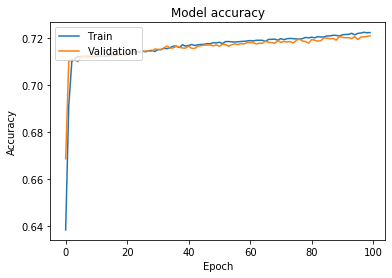

In [14]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

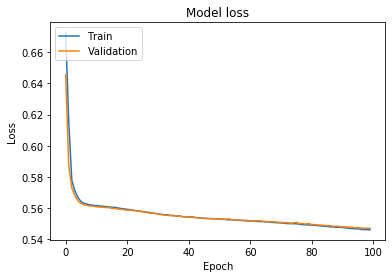

In [15]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
# Predict using X_test
y_pred = model.predict(X_test_nomood)

FH_pred = []
for i in y_pred:
    temp_list = []
    for binary in i:
        if binary >= 0.5:
            temp_list.append(1)
        else:
            temp_list.append(0)
    FH_pred.append(temp_list)

FH_prediction = pd.DataFrame(data=FH_pred, columns=['mood_0', 'mood_1', 'mood_2', 'mood_3', 'mood_4'])

In [17]:
# All unique outcomes
check_pos = []
for ac in FH_pred:
    if ac not in check_pos:
        check_pos.append(ac)
print(check_pos)

[[1, 1, 1, 0, 0], [1, 1, 0, 0, 0], [1, 0, 0, 0, 0], [1, 1, 1, 1, 0], [1, 1, 1, 1, 1], [0, 0, 0, 0, 0]]


In [18]:
pred = FH_prediction.sum(axis=1)
test = y_test['bored'].values

In [19]:
pred.value_counts()

3    1337
2     974
1     214
4      85
5      34
0       1
dtype: int64

In [20]:
y_test['bored'].unique()

array([0, 4, 1, 3, 2, 5])

In [21]:
X_test_onlyboredlast[:5]

,bored_last
14505,0.0
7553,4.0
4100,2.0
11825,0.0
12929,0.0


In [22]:
# Accuracy score
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 14.669187145557656


In [23]:
# true = y_test
# pred = y_pred
# last_value = X_bored_lastarray
same_correct = 0
same_wrong = 0
dif_correct = 0
dif_wrong = 0

X_test_bored = X_test_onlyboredlast['bored_last'].values
for i in range(len(pred)):
    if (test[i] == X_test_bored[i]) and (test[i] == pred[i]):
        same_correct += 1
    if (test[i] == X_test_bored[i]) and (test[i] != pred[i]):
        same_wrong += 1
    if (test[i] != X_test_bored[i]) and (test[i] == pred[i]):
        dif_correct += 1
    if (test[i] != X_test_bored[i]) and (test[i] != pred[i]):
        dif_wrong += 1   

print("       ", "Same", "Dif")
print("correct", same_correct, dif_correct)
print("wrong  ", same_wrong, dif_wrong)

#Check if table is similar to accuracy
print("")
print("Accuracy of table is: ", ((same_correct+dif_correct) / (same_correct+dif_correct+same_wrong+dif_wrong)))
print("Accuracy of model is: ", a)

        Same Dif
correct 213 175
wrong   1568 689

Accuracy of table is:  0.14669187145557655
Accuracy of model is:  0.14669187145557655


In [24]:
from collections import Counter
print("Predicted values: ", Counter(pred))
print("True values: ", Counter(test))
print("Previous mood:", Counter(X_test_bored))

Predicted values:  Counter({3: 1337, 2: 974, 1: 214, 4: 85, 5: 34, 0: 1})
True values:  Counter({0: 1264, 1: 491, 2: 455, 3: 301, 4: 119, 5: 15})
Previous mood: Counter({0.0: 1286, 1.0: 494, 2.0: 451, 3.0: 294, 4.0: 106, 5.0: 14})


In [25]:
same_correct_0, same_wrong_0, same_correct_1, same_wrong_1, same_correct_2, same_wrong_2, same_correct_3, same_wrong_3, same_correct_4, same_wrong_4, same_correct_5, same_wrong_5 = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
dif_correct_0, dif_wrong_0, dif_correct_1, dif_wrong_1, dif_correct_2, dif_wrong_2, dif_correct_3, dif_wrong_3, dif_correct_4, dif_wrong_4, dif_correct_5, dif_wrong_5 = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

for i in range(len(pred)):
    if test[i] == 0 and pred[i] == 0:
        if test[i] == X_test_bored[i]:
            same_correct_0 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_0 += 1
    if test[i] == 0 and pred[i] != 0:
        if test[i] == X_test_bored[i]:
            same_wrong_0 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_0 += 1

    if test[i] == 1 and pred[i] == 1:
        if test[i] == X_test_bored[i]:
            same_correct_1 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_1 += 1
    if test[i] == 1 and pred[i] != 1:
        if test[i] == X_test_bored[i]:
            same_wrong_1 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_1 += 1
        
    if test[i] == 2 and pred[i] == 2:
        if test[i] == X_test_bored[i]:
            same_correct_2 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_2 += 1
    if test[i] == 2 and pred[i] != 2:
        if test[i] == X_test_bored[i]:
            same_wrong_2 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_2 += 1
    
    if test[i] == 3 and pred[i] == 3:
        if test[i] == X_test_bored[i]:
            same_correct_3 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_3 += 1
    if test[i] == 3 and pred[i] != 3:
        if test[i] == X_test_bored[i]:
            same_wrong_3 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_3 += 1
        
    if test[i] == 4 and pred[i] == 4:
        if test[i] == X_test_bored[i]:
            same_correct_4 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_4 += 1
    if test[i] == 4 and pred[i] != 4:
        if test[i] == X_test_bored[i]:
            same_wrong_4 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_4 += 1
    
    if test[i] == 5 and pred[i] == 5:
        if test[i] == X_test_bored[i]:
            same_correct_5 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_5 += 1
    if test[i] == 5 and pred[i] != 5:
        if test[i] == X_test_bored[i]:
            same_wrong_5 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_5 += 1

print("Total length: ", len(X_test_bored))

print("Same Correct 0 guesses is: ", same_correct_0)
print("Same Wrong 0 guesses is: ", same_wrong_0)
print("Dif Correct 0 guesses is: ", dif_correct_0)
print("Dif Wrong 0 guesses is: ", dif_wrong_0)
print('')
print("Same Correct 1 guesses is: ", same_correct_1)
print("Same Wrong 1 guesses is: ", same_wrong_1)
print("Dif Correct 1 guesses is: ", dif_correct_1)
print("Dif Wrong 1 guesses is: ", dif_wrong_1)
print('')
print("Same Correct 2 guesses is: ", same_correct_2)
print("Same Wrong 2 guesses is: ", same_wrong_2)
print("Dif Correct 2 guesses is: ", dif_correct_2)
print("Dif Wrong 2 guesses is: ", dif_wrong_2)
print('')
print("Same Correct 3 guesses is: ", same_correct_3)
print("Same Wrong 3 guesses is: ", same_wrong_3)
print("Dif Correct 3 guesses is: ", dif_correct_3)
print("Dif Wrong 3 guesses is: ", dif_wrong_3)
print('')
print("Same Correct 4 guesses is: ", same_correct_4)
print("Same Wrong 4 guesses is: ", same_wrong_4)
print("Dif Correct 4 guesses is: ", dif_correct_4)
print("Dif Wrong 4 guesses is: ", dif_wrong_4)
print('')
print("Same Correct 5 guesses is: ", same_correct_5)
print("Same Wrong 5 guesses is: ", same_wrong_5)
print("Dif Correct 5 guesses is: ", dif_correct_5)
print("Dif Wrong 5 guesses is: ", dif_wrong_5)

Total length:  2645
Same Correct 0 guesses is:  0
Same Wrong 0 guesses is:  1039
Dif Correct 0 guesses is:  0
Dif Wrong 0 guesses is:  225

Same Correct 1 guesses is:  18
Same Wrong 1 guesses is:  254
Dif Correct 1 guesses is:  28
Dif Wrong 1 guesses is:  191

Same Correct 2 guesses is:  86
Same Wrong 2 guesses is:  146
Dif Correct 2 guesses is:  91
Dif Wrong 2 guesses is:  132

Same Correct 3 guesses is:  109
Same Wrong 3 guesses is:  74
Dif Correct 3 guesses is:  53
Dif Wrong 3 guesses is:  65

Same Correct 4 guesses is:  0
Same Wrong 4 guesses is:  55
Dif Correct 4 guesses is:  3
Dif Wrong 4 guesses is:  61

Same Correct 5 guesses is:  0
Same Wrong 5 guesses is:  0
Dif Correct 5 guesses is:  0
Dif Wrong 5 guesses is:  15


In [27]:
mae_0, mae_1, mae_2, mae_3, mae_4, mae_5 = (0,0,0,0,0,0)

for i in range(len(pred)):
    if test[i] == 0 and pred[i] != 0:
        mae_0 += (abs(test[i]-pred[i]))
    if test[i] == 1 and pred[i] != 1:
        mae_1 += (abs(test[i]-pred[i]))
    if test[i] == 2 and pred[i] != 2:
        mae_2 += (abs(test[i]-pred[i]))
    if test[i] == 3 and pred[i] != 3:
        mae_3 += (abs(test[i]-pred[i]))
    if test[i] == 4 and pred[i] != 4:
        mae_4 += (abs(test[i]-pred[i]))
    if test[i] == 5 and pred[i] != 5:
        mae_5 += (abs(test[i]-pred[i]))

cnt_0, cnt_1, cnt_2, cnt_3, cnt_4, cnt_5 = (0,0,0,0,0,0)
for z in range(len(test)):
    if test[z] == 0:
        cnt_0 += 1
    if test[z] == 1:
        cnt_1 += 1
    if test[z] == 2:
        cnt_2 += 1
    if test[z] == 3:
        cnt_3 += 1
    if test[z] == 4:
        cnt_4 += 1
    if test[z] == 5:
        cnt_5 += 1

mae_macroaverage = ((mae_0/cnt_0) + (mae_1/cnt_1) + (mae_2/cnt_2) + (mae_3/cnt_3) + (mae_4/cnt_4) + (mae_5/cnt_5)) / 6

In [30]:
print("Macro-averaged Mean Absolute error is: ", round(mae_macroaverage, 4))
print("Macro-averaged F1-score is: ", round(f1_score(test, pred, average='weighted'), 4))

Macro-averaged Mean Absolute error is:  1.5063
Macro-averaged F1-score is:  0.0907
